# Inflated 3D CNN Implementation - Design Alternative 2

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


## Create the dataset

#### Import Libraries and Configure Device

In [1]:
## Uncomment if you are running on colab

#!pip install keras-tuner imageio opencv-python imageio tqdm tensorflow[and-cuda] pandas matplotlib scikit-learn seaborn einops
#!pip install -q git+https://github.com/tensorflow/docs

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

In [2]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections 
import os

import imageio
import shutil
import cv2
import mediapipe as mp
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow_docs.vis import embed
import tensorflow as tf
import keras
import keras_tuner as kt
from keras import layers

2024-11-28 04:35:10.162351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732739710.724472  217494 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732739710.881959  217494 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 04:35:12.323951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
## Limit usage of VRAM to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_virtual_device_configuration(gpu,
                                                             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5820)])

`Note`: Ikaw bahala sa pag lagay ng memory limit, check your gpu specs and refer to that specs when changing.

#### Visualize the data first

In [4]:
def visulize_data(fil_dir):
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)),
                                  len(all_class_names)-random.randrange(1, len(all_class_names)))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

#### Loading of dataset

In [ ]:
## Define the dimensions of frames in the set of frames created (Default params muna)
HEIGHT = 224
WIDTH = 224
SEQUENCE_LENGTH = 30 # small frame raw para small memory at computation ang gawin, ndi kakakayanin ng mga nasa 16GB lang
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress'
          ]) # Eto muna

- `Note`: This can be changed later on once model is okay

In [6]:
def split_dataset(dataset_dir,
                  splits={"train": 0.7, "val": 0.15, "test": 0.15},
                  seed=42,
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Args:
        dataset_dir: Path to the main dataset directory containing all class folders.
        splits: Dictionary defining the proportion for the train, val, and test splits (must sum to 1).
        seed: Random seed for reproducibility.
        selected_classes: List of class names to include in the split. If None, includes all classes.

    Returns:
        Split of classes in folders train, test, and val
    """
    random.seed(seed)

    # Create the splits directories if they don't exist
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]
    for split in splits_dirs:
        (dataset_dir / split).mkdir(parents=True, exist_ok=True)

    # Iterate over each class folder in the dataset
    class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]

    # Filter classes if `selected_classes` is provided
    if selected_classes:
        class_dirs = [f for f in class_dirs if f.name in selected_classes]

    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"):
        print(f"\nProcessing class: {class_dir.name}")

        # Get a list of video files in the class directory
        video_files = [f for f in class_dir.iterdir() if f.is_file()]

        # Shuffle the video files for randomness
        random.shuffle(video_files)

        # Calculate the split indices based on the provided proportions
        num_videos = len(video_files)
        train_end = int(splits["train"] * num_videos)
        val_end = train_end + int(splits["val"] * num_videos)

        # Split the video files into train, val, and test sets
        train_files = video_files[:train_end]
        val_files = video_files[train_end:val_end]
        test_files = video_files[val_end:]

        for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
            split_dir = dataset_dir / split / class_dir.name
            split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory

            for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                shutil.move(str(file), str(split_dir / file.name))

    print("\nDataset split complete!")


In [7]:
## File path
file_path = './Workout/' 

In [8]:
## Split the dataset, automatically returns 0 if already run once
#split_dataset(file_path, splits={"train": 0.7, "val": 0.15, "test": 0.15}, selected_classes=LABELS)

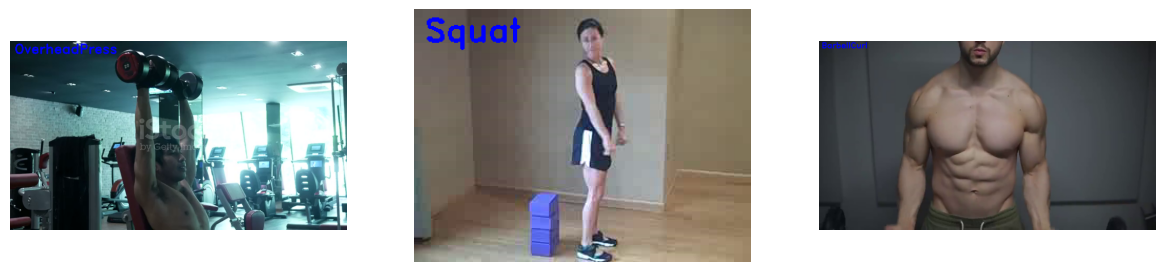

In [9]:
visulize_data(file_path + 'train/')

In [10]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.PosixPath(f'{file_path}train'),
                    'val':pathlib.PosixPath(f'{file_path}val'),
                    'test':pathlib.PosixPath(f'{file_path}test')}

#### Create Frames from each video

In [11]:
def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [12]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224)):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(1, video_length // n_frames)

    if video_length <= n_frames:
        start = 0
    else:
        max_start = video_length - n_frames * frame_step
        start = random.randint(0, max_start)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    
    if ret:
        result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            result.append(format_frames(frame, output_size))
        else:
            result.append(np.zeros_like(result[0]))

    src.release()
    result = np.array(result)[..., [2, 1, 0]]
    return result

In [13]:
def augment_frames(frames):
    augmented_frames = []
    for frame in frames:
        frame = tf.image.random_flip_left_right(frame)
        frame = tf.image.random_brightness(frame, max_delta=0.2)
        frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2)
        frame = tf.image.random_saturation(frame, lower=0.8, upper=1.2)
        augmented_frames.append(frame)
    return tf.stack(augmented_frames)

In [14]:
class FrameGenerator:
    def __init__(self, path, n_frames, training=False, augment=False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.augment = augment
        self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi')) + list(self.path.glob('*/*.mov')) + list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __call__(self):
        video_paths, classes = self.get_files_and_class_names()
        pairs = list(zip(video_paths, classes))
        if self.training:
            random.shuffle(pairs)

        for path, name in pairs:
            video_frames = frames_from_video_file(path, self.n_frames, output_size=(HEIGHT, WIDTH))
            if self.augment and self.training:
                video_frames = augment_frames(video_frames)
            label = self.class_ids_for_name[name]
            yield video_frames, label

In [15]:
## Pinagsama ko na yung framgen at output sig
def configure_dataset(dataset_path, n_frames, batch_size=2, training=False, augment=False):
    frame_gen = FrameGenerator(dataset_path, n_frames, training=training, augment=augment)
    output_signature = (
        tf.TensorSpec(shape=(SEQUENCE_LENGTH, HEIGHT, WIDTH, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int16)
    )
    ds = tf.data.Dataset.from_generator(frame_gen, output_signature=output_signature)
    if training:
        ds = ds.cache().shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

#### Split Generate the datasets

In [16]:
train_ds = configure_dataset(dataset_paths['train'], SEQUENCE_LENGTH, training=True, augment=True)

# Create the training set
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

I0000 00:00:1732739742.298130  217494 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5820 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6
2024-11-28 04:35:52.919094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 16 of 1000
2024-11-28 04:36:16.249031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 52 of 1000
2024-11-28 04:36:32.772827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 84 of 1000
2024-11-28 04:36:42.679775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 108 of 1000
2024-11-28 04:36:53.034806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffl

Shape of training set of frames: (2, 30, 224, 224, 3)
Shape of training labels: (2,)


2024-11-28 04:38:37.264622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [17]:
val_ds = configure_dataset(dataset_paths['val'], SEQUENCE_LENGTH, training=False)

# Create the training set
val_frames, val_labels = next(iter(val_ds))
print(f'Shape of testing set of frames: {val_frames.shape}')
print(f'Shape of testing labels: {val_labels.shape}')

Shape of testing set of frames: (2, 30, 224, 224, 3)
Shape of testing labels: (2,)


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

- `Important Note`: When training mamaya, make sure na ang loss is set to 'sparse_categorical_crossentropy' as it does not use any one hot encoded, tas naka raw logits pa siya, kaya no usage of 'softmax'

#### Plotting Functions for later

In [18]:
def plot_history(history):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2)

    fig.set_size_inches(18.5, 10.5)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'test')
    ax1.set_ylabel('Loss')

    # Determine upper bound of y-axis
    max_loss = max(history.history['loss'] + history.history['val_loss'])

    ax1.set_ylim([0, np.ceil(max_loss)])
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'],  label = 'train')
    ax2.plot(history.history['val_accuracy'], label = 'test')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'])

    plt.show()

In [19]:
def get_actual_predicted_labels(dataset, trained_model):
    """
        Create a list of actual ground truth values and the predictions from the model.

        Args:
        dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

        Return:
        Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = trained_model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [20]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
      Calculate the precision and recall of a classification model using the ground truth and
      predicted values.

      Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.

      Return:
        Precision and recall measures.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm) # Diagonal represents true positives
    precision = dict()
    recall = dict()
    for i in range(len(labels)):
      col = cm[:, i]
      fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

      row = cm[i, :]
      fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

      precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

      recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    return precision, recall

In [21]:
def calculate_f1_score(y_actual, y_pred, labels, average='macro'):
    """
    Calculate F1-Score for each class and optionally a macro-average.

    Args:
        y_actual: Ground truth labels.
        y_pred: Predicted labels.
        labels: List of classification labels.
        average: 'macro' to return average F1-score, 'none' to return per-class F1-score.

    Returns:
        A dictionary of F1-Scores per class and/or the macro-average F1-Score.
    """
    cm = tf.math.confusion_matrix(y_actual, y_pred)
    tp = np.diag(cm)  # True positives (diagonal of confusion matrix)
    precision = tp / (np.sum(cm, axis=0) + 1e-7)  # Avoid division by zero
    recall = tp / (np.sum(cm, axis=1) + 1e-7)

    f1_scores = {label: 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-7)
                 for i, label in enumerate(labels)}

    if average == 'macro':
        macro_f1 = np.mean(list(f1_scores.values()))
        return f1_scores, macro_f1

    return f1_scores

In [22]:
from sklearn.metrics import average_precision_score

def calculate_map(y_actual, y_pred, num_classes):
    """
    Calculate the Mean Average Precision (mAP) for multi-class classification.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        num_classes: The number of classes in the dataset.

    Returns:
        map_score: The Mean Average Precision score.
    """
    # Convert the actual labels to one-hot encoding for mAP calculation
    y_actual_one_hot = np.eye(num_classes)[y_actual]
    
    aps = []
    for i in range(num_classes):
        # Average precision for each class (using one-vs-rest strategy)
        ap = average_precision_score(y_actual_one_hot[:, i], y_pred[:, i])
        aps.append(ap)

    map_score = np.mean(aps)
    return map_score


In [23]:
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(y_actual, y_pred, labels):
    """
    Plot Precision-Recall curve and calculate AUC for each class.

    Args:
        y_actual: Ground truth labels (class indices).
        y_pred: Predicted probabilities (e.g., softmax outputs from the model).
        labels: List of class names.

    Returns:
        auc_scores: Dictionary of AUC-PR for each class.
    """
    auc_scores = {}
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(labels):
        # Calculate Precision and Recall values for each class
        precision, recall, _ = precision_recall_curve(y_actual == i, y_pred[:, i])
        pr_auc = auc(recall, precision)
        auc_scores[label] = pr_auc

        # Plot the precision-recall curve for each class
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_scores

## Model Structuring, HyperTuning, and Training

This Network Architecture is from the paper [Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset](https://arxiv.org/abs/1705.07750)

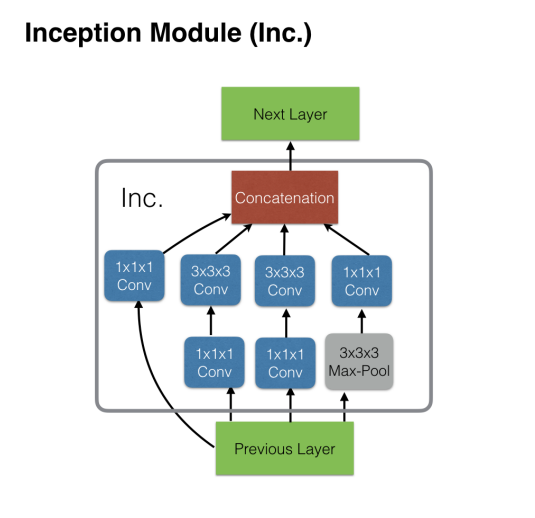

- `Note`: The structure of the is based on the figure above, we might modify it to tailor our project design's specific objectives

In [24]:
@keras.saving.register_keras_serializable()
class InflatedInceptionModule(keras.layers.Layer):
    def __init__(self, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, **kwargs):
        """
        Inflated Inception module for processing spatiotemporal data (video).
        The module includes spatial and temporal convolutions and pooling.
        """
        super().__init__(**kwargs)

        # 1x1 convolution branch
        self.conv_1x1 = layers.Conv3D(filters_1x1, kernel_size=(1, 1, 1), padding='same', activation='relu')

        # 3x3 convolution branch with reduction
        self.conv_3x3_reduce = layers.Conv3D(filters_3x3_reduce, kernel_size=(1, 1, 1), padding='same', activation='relu')
        self.conv_3x3 = layers.Conv3D(filters_3x3, kernel_size=(3, 3, 3), padding='same', activation='relu')

        # 5x5 convolution branch with reduction
        self.conv_5x5_reduce = layers.Conv3D(filters_5x5_reduce, kernel_size=(1, 1, 1), padding='same', activation='relu')
        self.conv_5x5 = layers.Conv3D(filters_5x5, kernel_size=(5, 5, 5), padding='same', activation='relu')

        # Pooling branch with projection
        self.pool_proj = layers.MaxPooling3D(pool_size=(3, 3, 3), strides=(1, 1, 1), padding='same')
        self.pool_proj_conv = layers.Conv3D(filters_pool_proj, kernel_size=(1, 1, 1), padding='same', activation='relu')

        # Concatenation layer to combine the outputs of each branch
        self.concat = layers.Concatenate(axis=-1)

    def call(self, inputs):
        # Apply 1x1 convolution branch
        branch1x1 = self.conv_1x1(inputs)

        # Apply 3x3 convolution branch
        branch3x3 = self.conv_3x3_reduce(inputs)
        branch3x3 = self.conv_3x3(branch3x3)

        # Apply 5x5 convolution branch
        branch5x5 = self.conv_5x5_reduce(inputs)
        branch5x5 = self.conv_5x5(branch5x5)

        # Apply pooling branch with projection
        branch_pool = self.pool_proj(inputs)
        branch_pool = self.pool_proj_conv(branch_pool)

        # Concatenate all branches
        outputs = self.concat([branch1x1, branch3x3, branch5x5, branch_pool])
        return outputs

#### Network Building and HyperTuning of Parameters

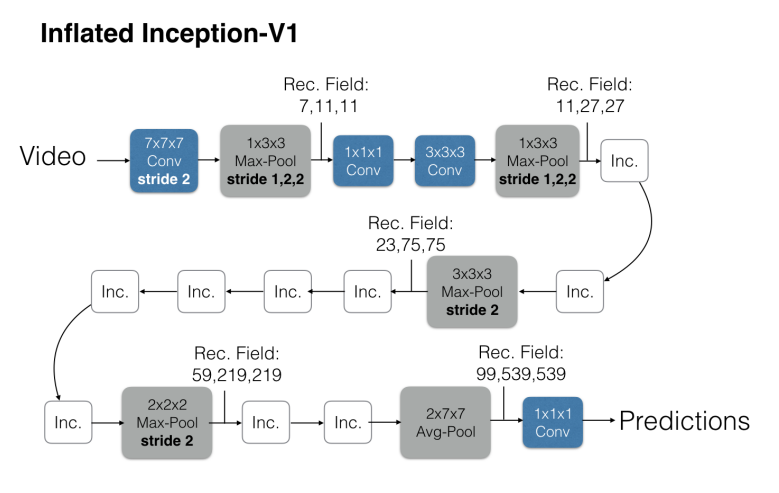

In [25]:
class I3D(kt.HyperModel):
    def __init__(self, num_classes, sequence_length, shape):
        self.num_classes = num_classes
        self.input_shape = (None, sequence_length, shape[0], shape[1], 3)

    def build(self, hp):
        video_input = layers.Input(shape=self.input_shape[1:], name='video_input')

        # I3D model architecture with Batch Normalization
        x = layers.Conv3D(
            filters=hp.Int('conv3d_filters1', min_value=16, max_value=64, step=16),
            kernel_size=(7, 7, 7),
            strides=(2, 2, 2),
            padding="same",
            activation="relu")(video_input)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling3D((3, 3, 3), strides=(1, 2, 2), padding="same")(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        x = layers.Conv3D(
            hp.Int('conv3d_filters2', min_value=32, max_value=128, step=32),
            (1, 1, 1),
            padding="same",
            activation="relu")(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        x = layers.Conv3D(
            filters=hp.Int('conv3d_filters3', min_value=64, max_value=256, step=64),
            kernel_size=(3, 3, 3),
            padding="same",
            activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling3D((3, 3, 3), strides=(1, 2, 2), padding="same")(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
        

        # Inflated Inception Modules
        x = InflatedInceptionModule(64, 96, 128, 16, 32, 32)(x)
        x = layers.LayerNormalization()(x)
        x = InflatedInceptionModule(128, 128, 192, 32, 96, 64)(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding="same")(x)
        x = InflatedInceptionModule(192, 96, 208, 16, 48, 64)(x)
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)

        # Pooling and Flattening
        x = layers.GlobalAveragePooling3D()(x)

        # Fully connected layers for classification
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(0.001, 0.001))(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(x)
        output = layers.Dense(len(LABELS))(x)  # Output layer for classification

        model = keras.models.Model(inputs=video_input, outputs=output)

        # Learning rate tuning for optimizers
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        if optimizer_choice == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
        else:
            optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9, epsilon=1e-7, centered=False)

        model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
        return model


- `Remarks`: Added a simple Batch normalization layer and reLU activation layer to the inception block

In [26]:
## Initialize the tuner to get best tuning
tuner = kt.BayesianOptimization(
    I3D(len(LABELS), SEQUENCE_LENGTH, (HEIGHT, WIDTH)),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='I3D',
    project_name='hyperparam_tuning'
)

In [27]:
## Start tuning
tuner.search(train_ds, validation_data=val_ds,
              epochs=10,
              )

Trial 5 Complete [00h 10m 48s]
val_accuracy: 0.39230769872665405

Best val_accuracy So Far: 0.5000000149011612
Total elapsed time: 00h 54m 07s


- `Take note:` If you are going to run the code above make sure you have enough memory, or change the epochs of the tuner to suit your devices specs. Naka 32 GB RAM si PC kaya medyo ok pa yang parameters, palitan mo na lang para hindi ka maubusan ng RAM memory.

In [28]:
# Show summary and get best model
model_2 = tuner.get_best_models(num_models=1)[0] # Gets the best model from the directory of tuned models
model_2.summary()

/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ video_input (InputLayer)        │ (None, 30, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 15, 112, 112,   │        32,960 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 112, 112,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 56, 56, 64) │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 56, 56, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 15, 56, 56,     │       331,968 │
│                                 │ 192)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 56, 56,     │           768 │
│ (BatchNormalization)            │ 192)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 15, 28, 28,     │             0 │
│                                 │ 192)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 28, 28,     │             0 │
│                                 │ 192)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inflated_inception_module       │ (None, 15, 28, 28,     │       436,080 │
│ (InflatedInceptionModule)       │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 15, 28, 28,     │           512 │
│ (LayerNormalization)            │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inflated_inception_module_1     │ (None, 15, 28, 28,     │     1,138,304 │
│ (InflatedInceptionModule)       │ 480)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 15, 28, 28,     │           960 │
│ (LayerNormalization)            │ 480)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 28, 28,     │             0 │
│                                 │ 480)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 8, 14, 14, 480) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inflated_inception_module_2     │ (None, 8, 14, 14, 512) │       812,400 │
│ (InflatedInceptionModule)       │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,823,396 (10.77 MB)

 Trainable params: 2,822,948 (10.77 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
frames, label = next(iter(train_ds))
model_2.build(frames)

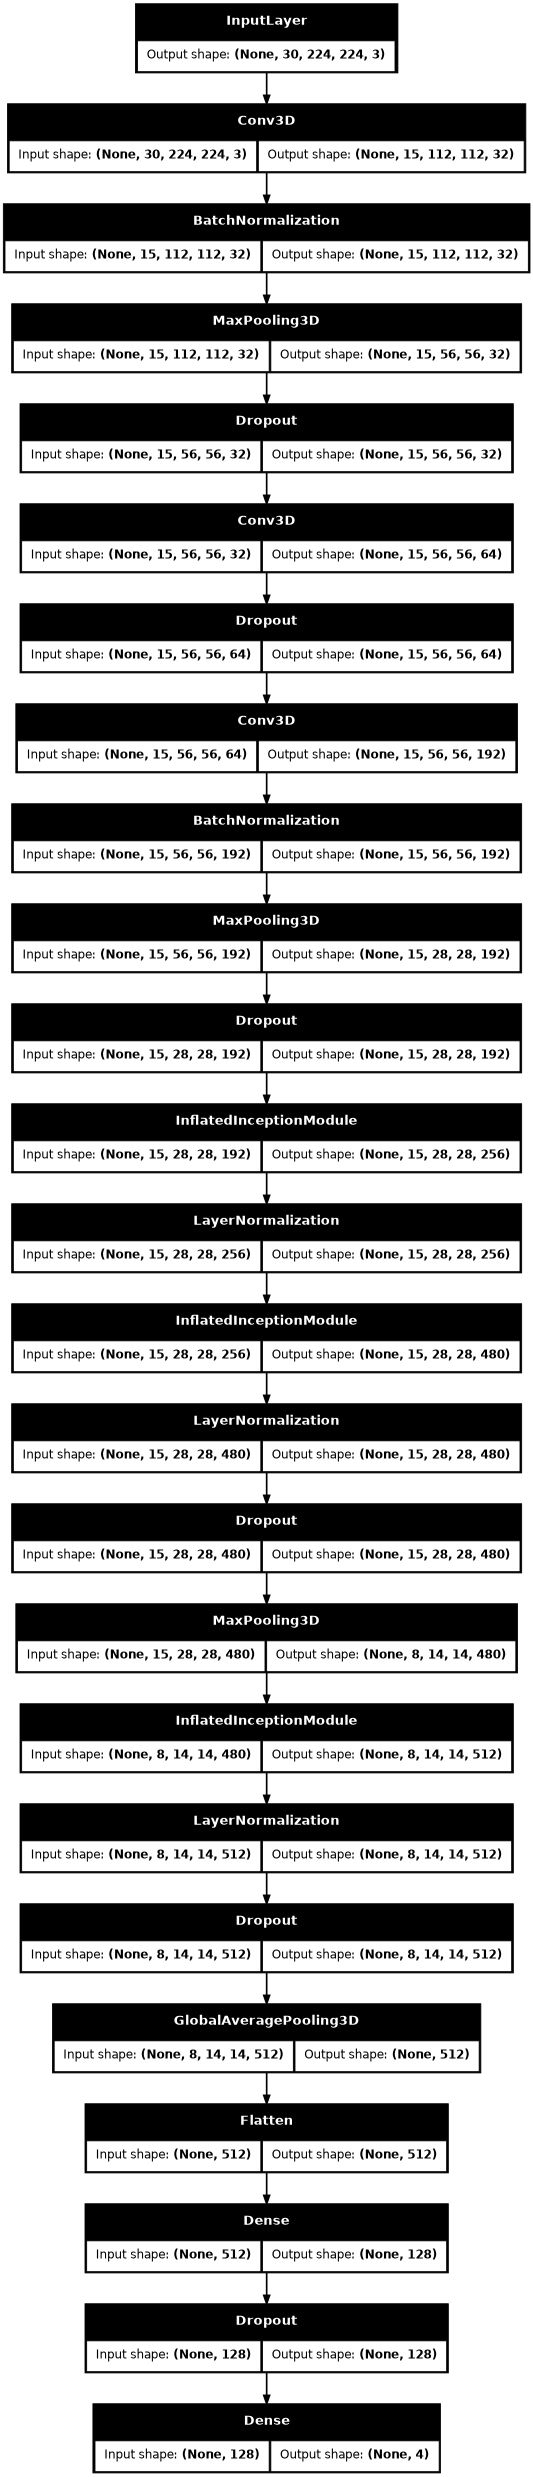

In [30]:
# Visualize the model
keras.utils.plot_model(model_2, expand_nested=True, dpi=60, show_shapes=True)

#### Train the model

In [31]:
# Create a callback that saves the model's weights while training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_I3D.keras',       
    save_weights_only=False,           
    save_best_only=True,                
    monitor='val_loss',                 
    mode='min',                         
)

early_stopping_model = keras.callbacks.EarlyStopping(
    monitor='val_loss',        
    patience=15,                
    min_delta=1e-4,            
    restore_best_weights=True  
)

In [32]:
history_2 = model_2.fit(x = train_ds,
                    epochs = 300, # You can change this if you want, ikaw bahala
                    callbacks=[checkpoint, early_stopping_model],
                    validation_data = val_ds)

Epoch 1/300


2024-11-28 05:33:01.895477: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_15', 96 bytes spill stores, 96 bytes spill loads



    155/Unknown 21s 62ms/step - accuracy: 0.4331 - loss: 1.4396

2024-11-28 05:33:11.855857: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-28 05:33:11.855897: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - accuracy: 0.4331 - loss: 1.4395 - val_accuracy: 0.4000 - val_loss: 1.5207
Epoch 2/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4534 - loss: 1.3971

2024-11-28 05:34:11.883633: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 229ms/step - accuracy: 0.4534 - loss: 1.3968 - val_accuracy: 0.5077 - val_loss: 1.2412
Epoch 3/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step - accuracy: 0.4907 - loss: 1.2704 - val_accuracy: 0.4923 - val_loss: 1.5072
Epoch 4/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4756 - loss: 1.2946

2024-11-28 05:34:58.297838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:34:58.297891: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.4757 - loss: 1.2945 - val_accuracy: 0.4462 - val_loss: 1.5343
Epoch 5/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.5000 - loss: 1.5401

2024-11-28 05:35:20.015045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:35:20.015094: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.4902 - loss: 1.2836 - val_accuracy: 0.4308 - val_loss: 1.5640
Epoch 6/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step - accuracy: 0.5563 - loss: 1.2651 - val_accuracy: 0.4308 - val_loss: 1.4472
Epoch 7/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 46s 300ms/step - accuracy: 0.5158 - loss: 1.2036 - val_accuracy: 0.4308 - val_loss: 1.4059
Epoch 8/300
  2/155 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8750 - loss: 0.4207

2024-11-28 05:37:08.935880: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:37:08.935932: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 210ms/step - accuracy: 0.5761 - loss: 1.0926 - val_accuracy: 0.3846 - val_loss: 1.2953
Epoch 9/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5733 - loss: 1.1219

2024-11-28 05:37:51.855110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:37:51.855143: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step - accuracy: 0.5730 - loss: 1.1221 - val_accuracy: 0.4154 - val_loss: 1.3926
Epoch 10/300
  2/155 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.2500 - loss: 1.0112    

2024-11-28 05:38:10.680524: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:38:10.680580: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5556 - loss: 1.1032

2024-11-28 05:38:22.823431: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:38:22.823464: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.5554 - loss: 1.1035 - val_accuracy: 0.4769 - val_loss: 1.2745
Epoch 11/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.5000 - loss: 1.0728

2024-11-28 05:38:41.179500: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:38:41.179553: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.4937 - loss: 1.1797 - val_accuracy: 0.3846 - val_loss: 1.3928
Epoch 12/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5741 - loss: 1.1124

2024-11-28 05:39:22.511114: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:39:22.511161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.5737 - loss: 1.1124 - val_accuracy: 0.3846 - val_loss: 1.5097
Epoch 13/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.5000 - loss: 0.9327

2024-11-28 05:39:42.777718: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:39:42.777772: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 201ms/step - accuracy: 0.5359 - loss: 1.0493 - val_accuracy: 0.4154 - val_loss: 1.3050
Epoch 14/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.5705 - loss: 1.0050 - val_accuracy: 0.3846 - val_loss: 1.4208
Epoch 15/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 1.0000 - loss: 0.8044

2024-11-28 05:40:44.680425: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:40:44.680472: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 209ms/step - accuracy: 0.5781 - loss: 1.0354 - val_accuracy: 0.4308 - val_loss: 1.2460
Epoch 16/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5289 - loss: 1.0246

2024-11-28 05:41:26.855506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:41:26.855544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842
2024-11-28 05:41:45.554198: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:41:45.554251: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 36s 235ms/step - accuracy: 0.5291 - loss: 1.0246 - val_accuracy: 0.5231 - val_loss: 1.1492
Epoch 17/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 180ms/step - accuracy: 0.5869 - loss: 0.9657 - val_accuracy: 0.3385 - val_loss: 1.5306
Epoch 18/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - accuracy: 0.6120 - loss: 1.0225 - val_accuracy: 0.3231 - val_loss: 1.5349
Epoch 19/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5685 - loss: 0.9735

2024-11-28 05:43:05.322759: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:43:05.322793: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.5685 - loss: 0.9735 - val_accuracy: 0.3538 - val_loss: 1.6092
Epoch 20/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.5000 - loss: 1.0592

2024-11-28 05:43:23.569596: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:43:23.569643: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 206ms/step - accuracy: 0.6215 - loss: 0.9084 - val_accuracy: 0.3846 - val_loss: 1.4723
Epoch 21/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5980 - loss: 0.9472

2024-11-28 05:44:05.097107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:44:05.097152: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step - accuracy: 0.5981 - loss: 0.9469 - val_accuracy: 0.4462 - val_loss: 1.3156
Epoch 22/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 1.0000 - loss: 0.6894

2024-11-28 05:44:25.409754: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:44:25.409801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6732 - loss: 0.8495

2024-11-28 05:44:35.031430: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:44:35.031473: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step - accuracy: 0.6730 - loss: 0.8498 - val_accuracy: 0.4923 - val_loss: 1.1683
Epoch 23/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 1.0000 - loss: 0.6773

2024-11-28 05:44:56.279273: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:44:56.279319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 199ms/step - accuracy: 0.6494 - loss: 0.9121 - val_accuracy: 0.4154 - val_loss: 1.5349
Epoch 24/300


2024-11-28 05:45:27.034383: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:45:27.034443: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6195 - loss: 0.8766

2024-11-28 05:45:36.892123: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step - accuracy: 0.6195 - loss: 0.8767 - val_accuracy: 0.4000 - val_loss: 1.5323
Epoch 25/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 29s 189ms/step - accuracy: 0.6710 - loss: 0.8522 - val_accuracy: 0.4923 - val_loss: 1.2501
Epoch 26/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 200ms/step - accuracy: 0.6633 - loss: 0.8900 - val_accuracy: 0.4308 - val_loss: 1.3326
Epoch 27/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.5000 - loss: 1.6613

2024-11-28 05:46:57.910908: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:46:57.910954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7143 - loss: 0.8405

2024-11-28 05:47:10.020954: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - accuracy: 0.7142 - loss: 0.8403 - val_accuracy: 0.2462 - val_loss: 2.0729
Epoch 28/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 1.0000 - loss: 0.0898

2024-11-28 05:47:29.105522: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10252191452569410515
2024-11-28 05:47:29.105570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 209ms/step - accuracy: 0.6613 - loss: 0.8368 - val_accuracy: 0.4769 - val_loss: 1.2960
Epoch 29/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 1.0000 - loss: 0.3226

2024-11-28 05:48:01.467846: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 31s 202ms/step - accuracy: 0.7326 - loss: 0.7424 - val_accuracy: 0.4462 - val_loss: 1.4179
Epoch 30/300
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 207ms/step - accuracy: 0.7332 - loss: 0.7217 - val_accuracy: 0.4308 - val_loss: 1.3042
Epoch 31/300
  1/155 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.5000 - loss: 0.6048

2024-11-28 05:49:04.628427: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8463258339865263842


155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step - accuracy: 0.7357 - loss: 0.7248 - val_accuracy: 0.4000 - val_loss: 1.7220


- `Remarks`: Why use more than 100 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad!

#### Plot the model and get the metrics

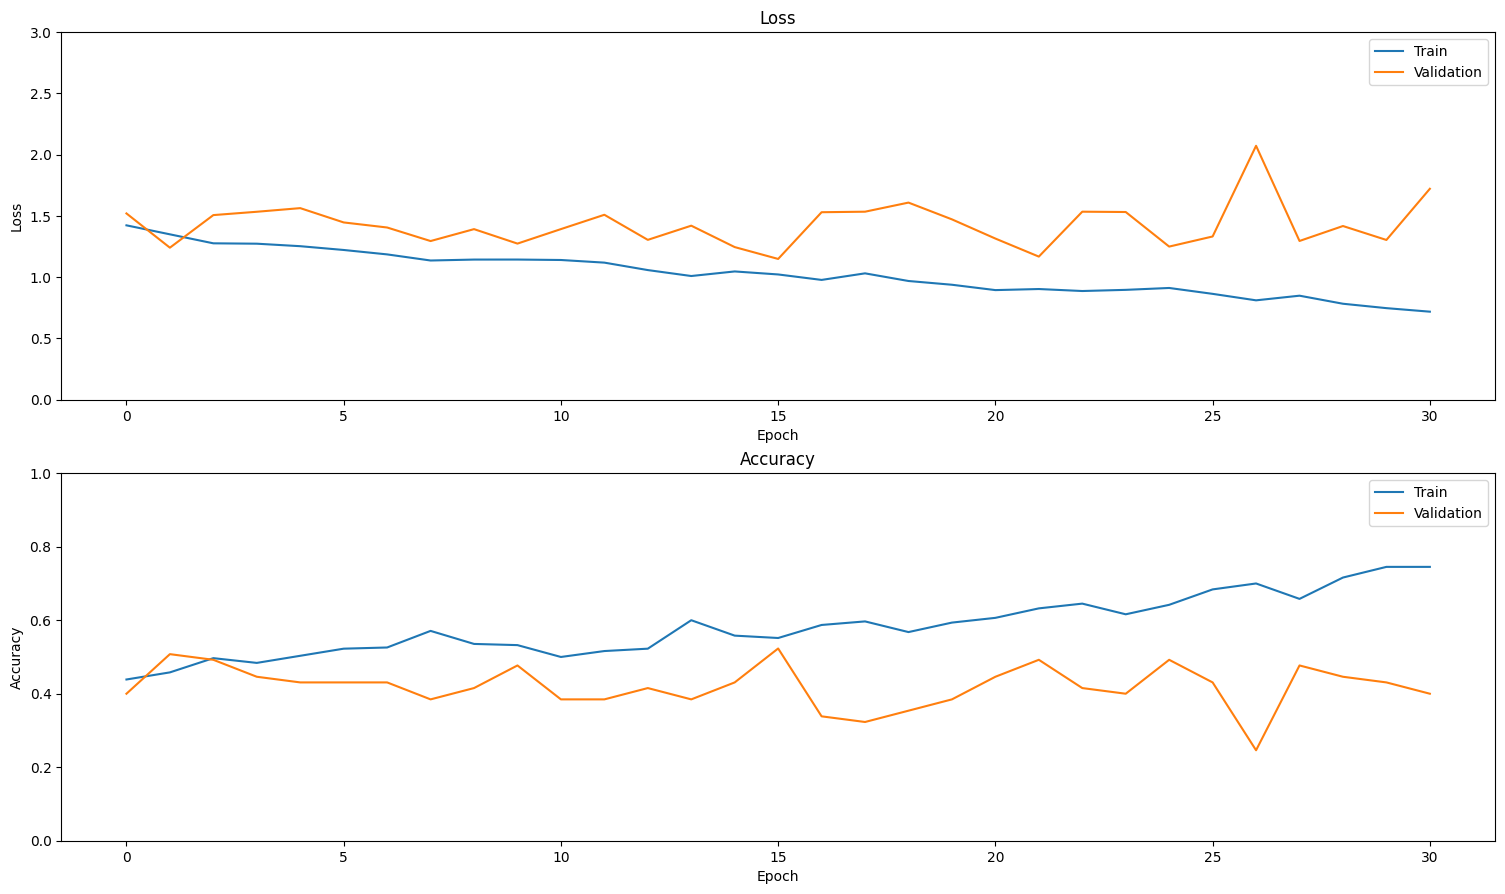

In [33]:
plot_history(history_2)

In [34]:
test_ds = configure_dataset(dataset_paths['test'], SEQUENCE_LENGTH, training=False)

# Create the training set
test_frames, test_labels = next(iter(test_ds))
print(f'Shape of training set of frames: {test_frames.shape}')
print(f'Shape of training labels: {test_labels.shape}')

Shape of training set of frames: (2, 30, 224, 224, 3)
Shape of training labels: (2,)


In [35]:
model_2.evaluate(test_ds, return_dict=True)

35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 859ms/step - accuracy: 0.4640 - loss: 1.1669


{'accuracy': 0.5571428537368774, 'loss': 1.1017906665802002}

In [36]:
fg = FrameGenerator(dataset_paths['train'], 10, training=True)
labels = list(fg.class_ids_for_name.keys())

155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


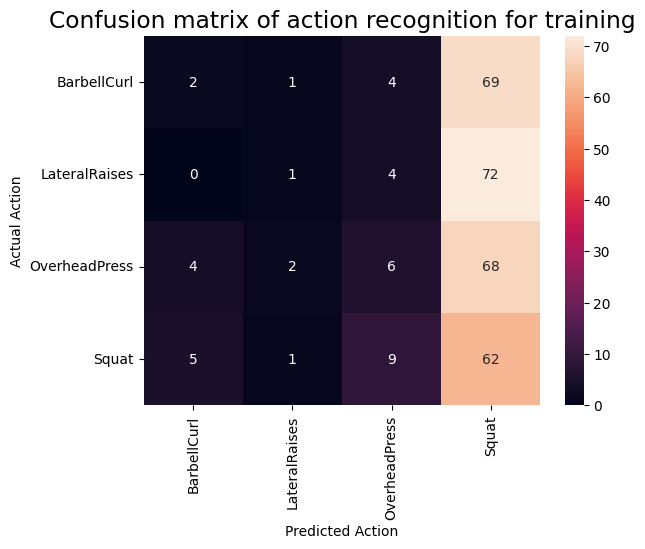

In [37]:
actual, predicted = get_actual_predicted_labels(train_ds, model_2)
plot_confusion_matrix(actual, predicted, labels, 'training')

35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 839ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


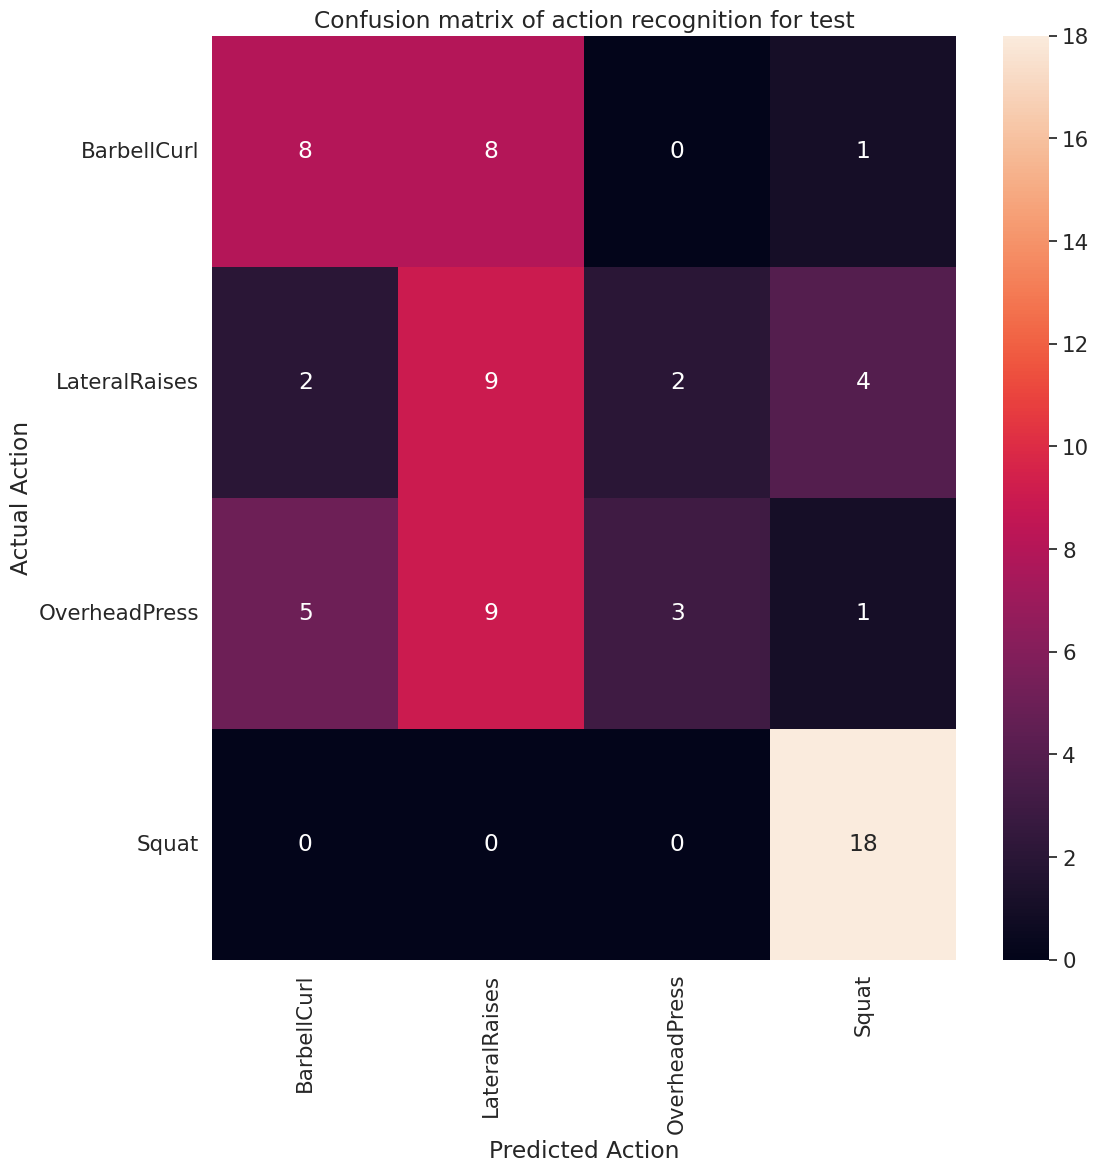

In [38]:
actual, predicted = get_actual_predicted_labels(test_ds, model_2)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [39]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [40]:
precision

{'BarbellCurl': 0.5333333333333333,
 'LateralRaises': 0.34615384615384615,
 'OverheadPress': 0.6,
 'Squat': 0.75}

In [41]:
recall

{'BarbellCurl': 0.47058823529411764,
 'LateralRaises': 0.5294117647058824,
 'OverheadPress': 0.16666666666666666,
 'Squat': 1.0}

#### Load Model

In [42]:
## Load model
load_model = keras.models.load_model('model_I3D.keras',
                                    custom_objects={'InflatedInceptionModule': InflatedInceptionModule,
                                                    })

/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'inflated_inception_module', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'inflated_inception_module_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391

#### Evaluate Model

In [43]:
actual, predicted = get_actual_predicted_labels(test_ds, load_model)

35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 777ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [44]:
f1_score = calculate_f1_score(actual, predicted, labels)
f1_score[1]

0.5085517358018377

In [45]:
proba = load_model.predict(test_ds)

35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 849ms/step


In [46]:
MAP = calculate_map(actual, proba, len(labels))
MAP

0.5747622822368306

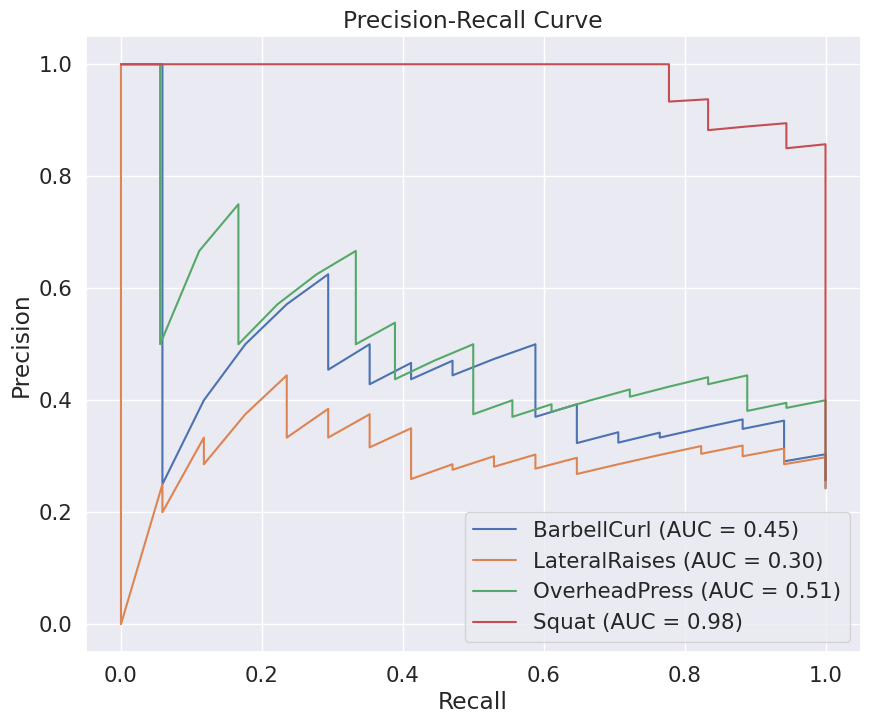

{'BarbellCurl': 0.4491096039133116,
 'LateralRaises': 0.30057326376568533,
 'OverheadPress': 0.5091244415357213,
 'Squat': 0.9759123264315475}

In [47]:
plot_precision_recall_curve(actual, proba, labels)

In [48]:
import time
import psutil

def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    cpu_start = process.cpu_percent()
    start = time.time()
    predictions = model.predict(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    cpu_usage = cpu_end - cpu_start
    return latency, cpu_usage

#### Test Model

In [49]:
sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/Deadlift2.mp4'


cap = cv2.VideoCapture(file_dir)
frames = []
total_lat = []
predicted_label = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Resize and convert color from BGR to RGB
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_frame = resized_frame[:, :, ::-1]

    frames.append(rgb_frame)

    display_text = f"Activity: {predicted_label}"
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.imshow('Cam', frame)

    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1]
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, 10, height, width, 3)

        prediction = load_model.predict(frames_array)
        latency, cpu_usage = measure_latency_cpu_usage(load_model, frames_array)
        total_lat.append(latency)

        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        frames = []

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Latency:", np.mean(total_lat))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
Failed to capture frame
Latency: 0.0565638542175293
